In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import glob
from statsmodels.tsa.arima_model import ARIMA
from tidegauge_functions import read_GPS_SONEL, read_GPS_nam14_UNAVCO, calc_rolling_decomposition_GPS
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [2]:
# Establish Components of file patern for UNAVCO Data
datum = '????'
ext = '.csv'
meth = '.cwu.nam14'
dir_in = 'data/GPS'

In [3]:
# Join File pattern components
pattern = os.path.join(dir_in, datum + meth + ext)
print(pattern)

data/GPS\????.cwu.nam14.csv


In [4]:
# Sort files using glob
filenames = sorted(glob.glob(pattern))

In [5]:
# Call all files and view them using 'head'
for f, filepath in enumerate(filenames):
    df = read_GPS_nam14_UNAVCO(filepath)
    print(f'\n\n{filepath}')
    print(df.head())



data/GPS\ASKY.cwu.nam14.csv
            North  East  Vertical  NorthSTD  EastSTD  VerticalSTD Quality
Date                                                                     
2007-08-20   0.00  0.00      0.00      2.00     1.53         9.87   repro
2007-08-21   1.82 -0.63     -2.30      2.02     1.53         9.82   repro
2007-08-22  -0.98  0.33     -3.36      2.01     1.54         9.82   repro
2007-08-23  -0.35 -1.54     -4.23      1.97     1.51         9.60   repro
2007-08-24  -0.76 -1.11     -1.18      2.05     1.57        10.15   repro


data/GPS\BLAS.cwu.nam14.csv
            North  East  Vertical  NorthSTD  EastSTD  VerticalSTD Quality
Date                                                                     
2008-07-08   0.00  0.00      0.00      1.91     1.59        10.91   repro
2008-07-09   0.30  0.73     -8.95      1.93     1.59        11.11   repro
2008-07-10   1.84 -0.15    -13.82      2.03     1.70        11.66   repro
2008-07-11  -0.48  0.64    -16.57      1.99     1.60

2007-09-01   0.28 -1.02      6.12      2.43     1.71         8.95   repro


data/GPS\KMJP.cwu.nam14.csv
            North  East  Vertical  NorthSTD  EastSTD  VerticalSTD Quality
Date                                                                     
2008-07-16   0.00  0.00      0.00      1.84     1.58        12.91   repro
2008-07-17   0.97  0.53     -2.31      1.78     1.59        12.41   repro
2008-07-18   1.93 -0.18     -4.24      1.83     1.61        12.59   repro
2008-07-19   0.58  0.48     -6.43      1.80     1.59        12.47   repro
2008-07-20   1.59 -0.05      3.32      1.73     1.54        12.08   repro


data/GPS\KMOR.cwu.nam14.csv
            North  East  Vertical  NorthSTD  EastSTD  VerticalSTD Quality
Date                                                                     
2007-09-04   0.00  0.00      0.00      1.80     1.49        11.49   repro
2007-09-05  -1.29 -0.19     -4.03      1.82     1.52        11.63   repro
2007-09-06  -0.96  0.26    -16.53      1.82     1.52

2007-09-02   0.55  3.01    -11.65      2.53     1.72        10.17   repro


data/GPS\RINK.cwu.nam14.csv
            North  East  Vertical  NorthSTD  EastSTD  VerticalSTD Quality
Date                                                                     
2007-08-31   0.00  0.00      0.00      2.34     1.69         9.92   repro
2007-09-01   1.60  0.62     -3.19      2.22     1.62         9.42   repro
2007-09-02   3.23  1.46     -4.04      2.41     1.73        10.25   repro
2007-09-03   5.34  0.76     -1.40      2.52     1.85        11.29   repro
2007-09-04   3.24  0.27      1.04      2.20     1.56         9.34   repro


data/GPS\SCBY.cwu.nam14.csv
            North  East  Vertical  NorthSTD  EastSTD  VerticalSTD Quality
Date                                                                     
2007-09-09   0.00  0.00      0.00      2.02     1.62        12.23   repro
2007-09-10  -1.05  0.48     -0.98      1.90     1.55        11.63   repro
2007-09-11   0.74 -1.11     -2.80      1.92     1.55

In [6]:
# Resample data to monthly
def monthly_averaging(df, site):
    
    df_monthly = df.dropna().resample('1M').mean()
    df_monthly.plot()
    plt.suptitle(f"{site} Monthly GPS Data")
    plt.show()
    
    return df_monthly

In [7]:
def decompose(df, var, period):  
    
    decomposition = seasonal_decompose(df[var], freq = period)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    decomposition.plot();
    df['denoised'] = df[var] - residual
    df['trend'] = trend
    print(f'\n\n{filepath}')
    print(df.head())
    
    return df

In [20]:
def test_SARIMAX_GPS_Monthly(df, var, site, steps, start, end, frequency):
    #Create SARIMAX Model
    mod = sm.tsa.statespace.SARIMAX(df_monthly[var].loc[df.index[0]: start].interpolate(), 
                                                        trend='n',
                                                        order=(4,1,1),
                                                        seasonal_order=(4,1,1,12),
                                                        enforce_stationarity=False,
                                                        enforce_invertibility=False,
                                                        freq= frequency)
    results_SARIMAX = mod.fit()
    
    # Getting 120 months
    SARIMAX_forecast = round(results_SARIMAX.forecast(steps), 2)
   
    # Creating an index
    idx = pd.date_range(start, end, freq=frequency)
 
    SARIMAX_forecast = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast))),
                                    columns=['Date','ForecastSSH']).set_index('Date')
    print(f'{site}')
    print(results_SARIMAX.summary())
    
    ##
#     df_monthly.plot()
#     plt.suptitle(f"{site} Monthly GPS Data")
# #     plt.savefig(f'figs/monthly_GPS_all_data_{site}.png')
#     plt.show()

    ##
#     plt.plot(df[var].dropna(), linestyle='', marker=',')
#     plt.plot(results_SARIMAX.fittedvalues, color='red') 
#     plt.suptitle(f"{site} SARIMAX Model GPS")
#     plt.savefig(f'figs/test_SARIMAX_MODEL_GPS_{site}.png')
#     plt.show()

    ##
    plt.plot(df[var].dropna(), color='black', marker=',', linestyle='', label='Data')
    plt.plot(results_SARIMAX.fittedvalues, color='red', label='SARIMAX model') 
    plt.plot(SARIMAX_forecast.ForecastSSH, color='blue', label='Forecast') 
    plt.suptitle(f'{site} SARIMAX GPS Forecast {start} to {end}')
    plt.ylabel('Vertical Land Motion [mm]')
    plt.legend()
    plt.savefig(f'figs/test_GPS_SARIMAX_forecast_{site}.png')
    plt.show()
    
    ## Plot forecast - data (residual?)
    plt.plot((SARIMAX_forecast.ForecastSSH) - df_monthly[var].dropna(), 
             color='black', marker='x', linestyle='-', label='Data')
    plt.suptitle(f'{site} SARIMAX  Forecast ERROR')
    plt.ylabel('Model Error (SARIMAX-GPS) [mm]')
    plt.savefig(f'figs/test_GPS_SARIMAX_forecast_ERROR_{site}.png')
    plt.show()


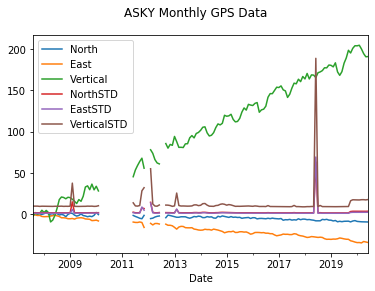

ASKY
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -157.040
Date:                            Wed, 29 Jul 2020   AIC                            336.080
Time:                                    17:00:37   BIC                            359.118
Sample:                                08-31-2007   HQIC                           345.091
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1203      1.001     -1.119      0.263      -3.083       0.842
ar.L2         -0.7150      0.6

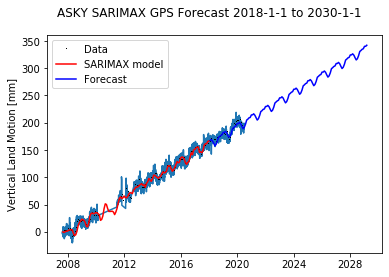

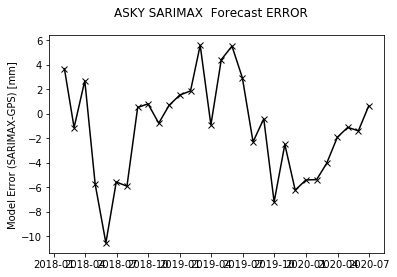

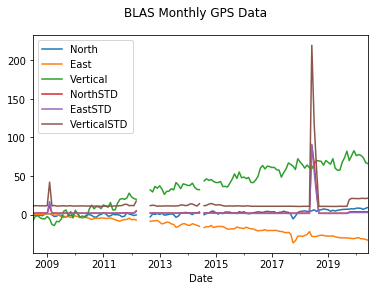

C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BLAS
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  114
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -127.346
Date:                            Wed, 29 Jul 2020   AIC                            276.692
Time:                                    17:01:05   BIC                            297.503
Sample:                                07-31-2008   HQIC                           284.588
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3550      0.182      1.947      0.052      -0.002       0.712
ar.L2          0.4379      0.2

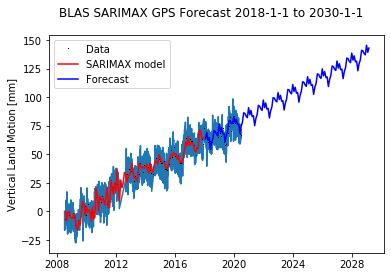

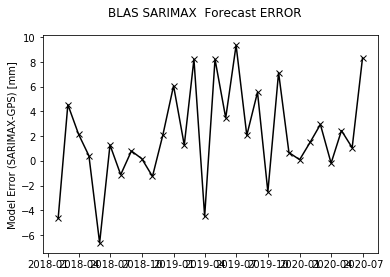

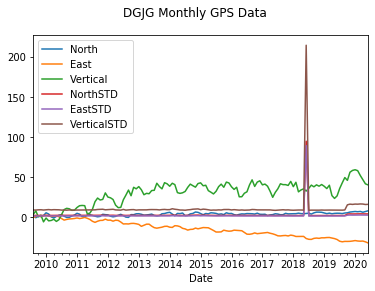

C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DGJG
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  101
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 -84.532
Date:                            Wed, 29 Jul 2020   AIC                            191.064
Time:                                    17:01:32   BIC                            208.482
Sample:                                08-31-2009   HQIC                           197.143
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1405      0.374     -3.046      0.002      -1.874      -0.407
ar.L2         -0.5426      0.3

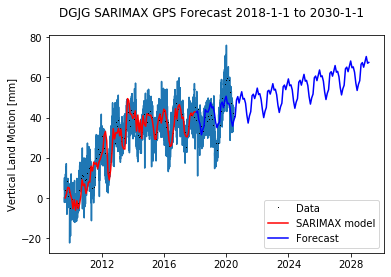

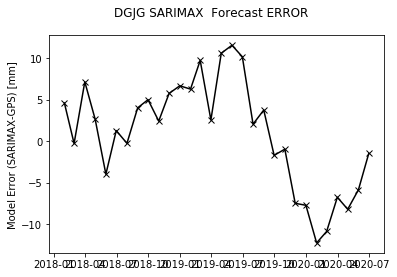

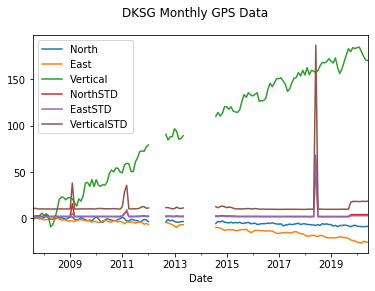

DKSG
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -157.489
Date:                            Wed, 29 Jul 2020   AIC                            336.978
Time:                                    17:01:45   BIC                            360.016
Sample:                                08-31-2007   HQIC                           345.990
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3174      0.402      0.790      0.430      -0.470       1.105
ar.L2         -0.1237      0.1

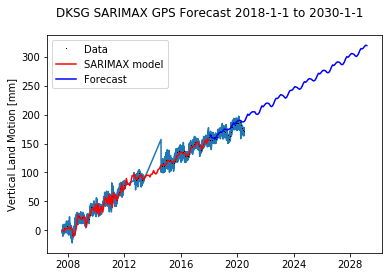

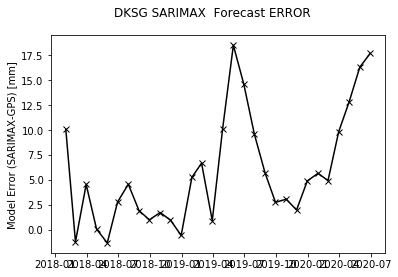

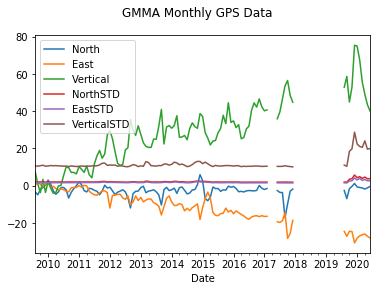

C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GMMA
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  101
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 -96.486
Date:                            Wed, 29 Jul 2020   AIC                            214.972
Time:                                    17:02:06   BIC                            232.391
Sample:                                08-31-2009   HQIC                           221.052
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7115      0.286      2.488      0.013       0.151       1.272
ar.L2         -0.2049      0.2

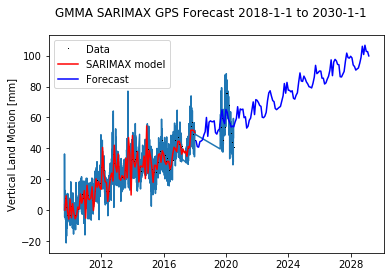

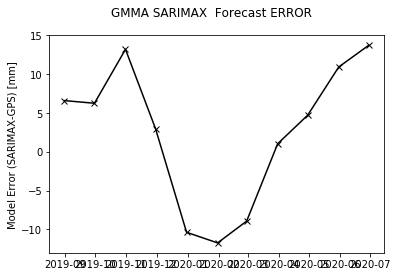

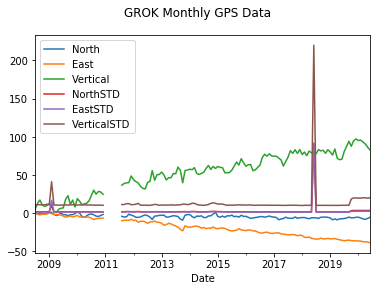

C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GROK
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  114
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -130.494
Date:                            Wed, 29 Jul 2020   AIC                            282.988
Time:                                    17:02:30   BIC                            303.798
Sample:                                07-31-2008   HQIC                           290.884
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2110      0.278      0.759      0.448      -0.334       0.756
ar.L2          0.1977      0.1

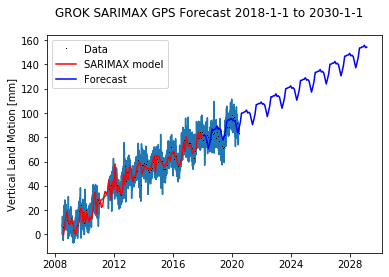

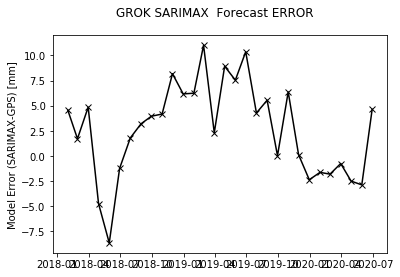

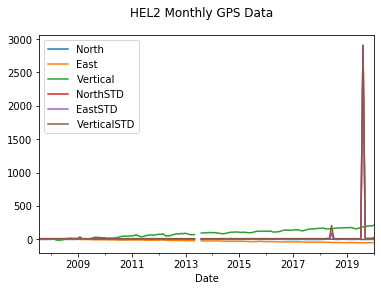

HEL2
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -168.028
Date:                            Wed, 29 Jul 2020   AIC                            358.056
Time:                                    17:02:49   BIC                            381.093
Sample:                                08-31-2007   HQIC                           367.067
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2284      0.691     -0.331      0.741      -1.582       1.125
ar.L2         -0.3439      0.2

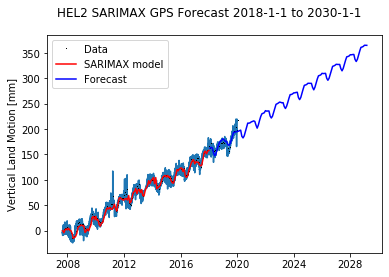

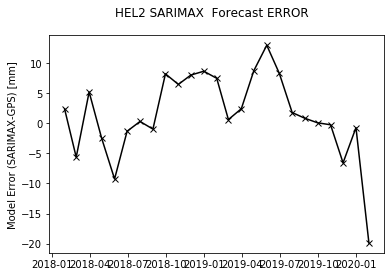

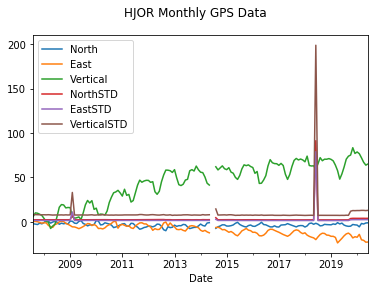

HJOR
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -145.761
Date:                            Wed, 29 Jul 2020   AIC                            313.521
Time:                                    17:03:06   BIC                            336.559
Sample:                                08-31-2007   HQIC                           322.532
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1631      0.451     -0.362      0.718      -1.047       0.721
ar.L2         -0.4513      0.1

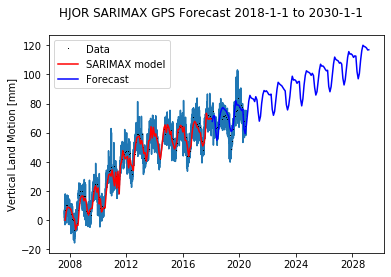

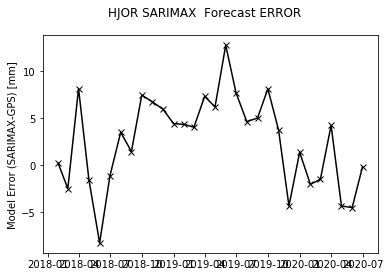

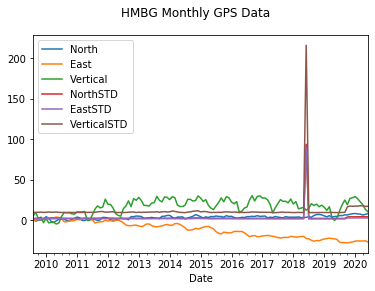

HMBG
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  101
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 -88.065
Date:                            Wed, 29 Jul 2020   AIC                            198.129
Time:                                    17:03:28   BIC                            215.548
Sample:                                08-31-2009   HQIC                           204.209
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2102      0.605     -1.999      0.046      -2.397      -0.023
ar.L2         -0.7542      0.5

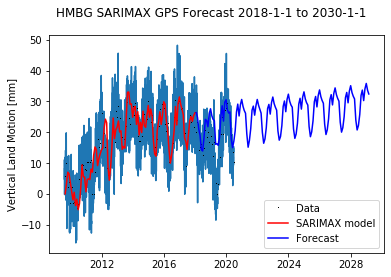

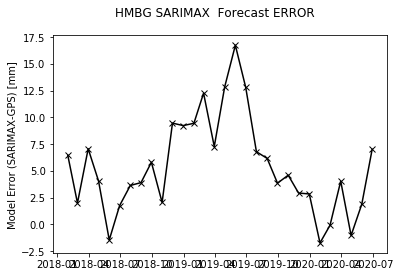

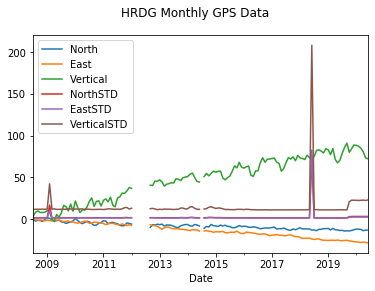

HRDG
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  114
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -127.885
Date:                            Wed, 29 Jul 2020   AIC                            277.770
Time:                                    17:03:43   BIC                            298.580
Sample:                                07-31-2008   HQIC                           285.665
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2897      0.175      1.658      0.097      -0.053       0.632
ar.L2          0.0358      0.1

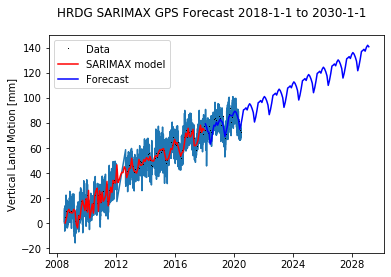

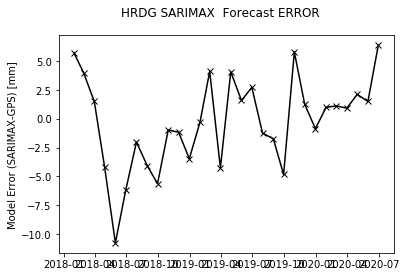

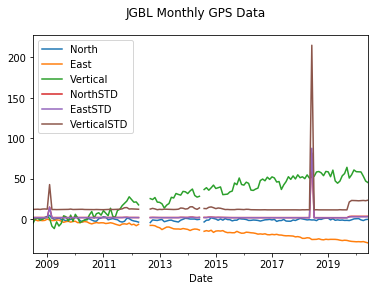

JGBL
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  114
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -129.640
Date:                            Wed, 29 Jul 2020   AIC                            281.281
Time:                                    17:04:09   BIC                            302.091
Sample:                                07-31-2008   HQIC                           289.176
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0150      0.269      0.056      0.956      -0.513       0.543
ar.L2         -0.0432      0.3

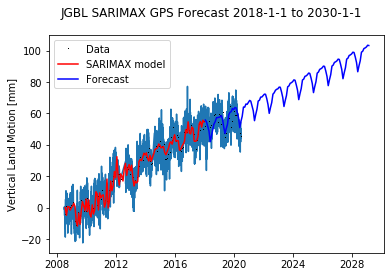

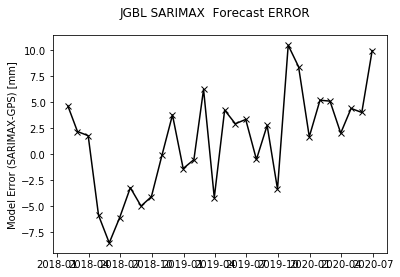

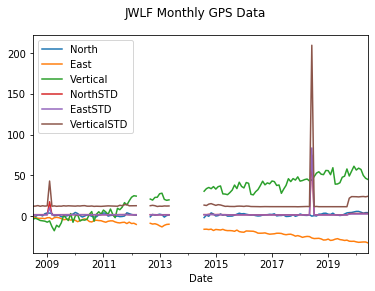

C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


JWLF
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  114
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -129.155
Date:                            Wed, 29 Jul 2020   AIC                            280.310
Time:                                    17:04:35   BIC                            301.120
Sample:                                07-31-2008   HQIC                           288.205
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1672      0.331     -3.524      0.000      -1.816      -0.518
ar.L2         -0.7054      0.2

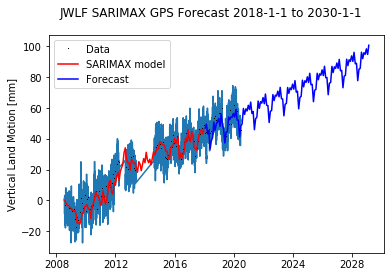

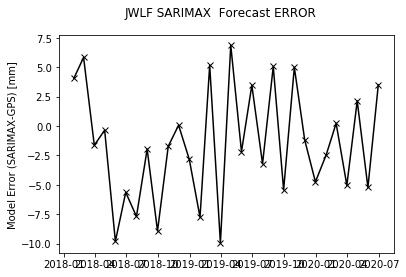

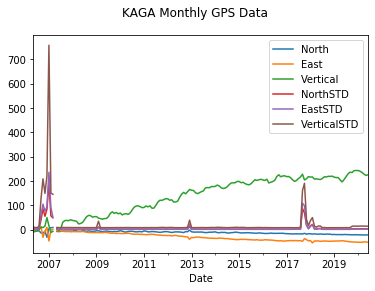

KAGA
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  140
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -220.447
Date:                            Wed, 29 Jul 2020   AIC                            462.895
Time:                                    17:04:51   BIC                            488.387
Sample:                                05-31-2006   HQIC                           473.074
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5238      0.742     -0.706      0.480      -1.979       0.931
ar.L2         -0.2271      0.2

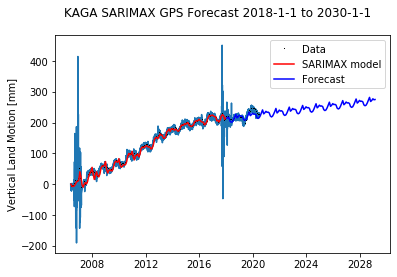

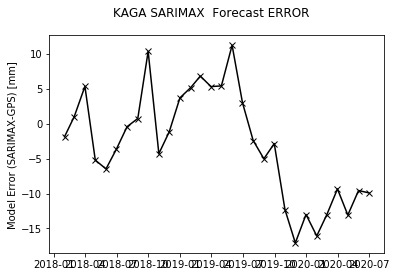

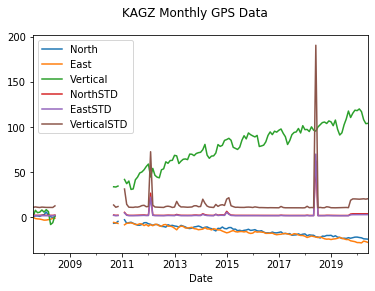

KAGZ
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -151.314
Date:                            Wed, 29 Jul 2020   AIC                            324.628
Time:                                    17:05:17   BIC                            347.665
Sample:                                08-31-2007   HQIC                           333.639
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3049      0.248      1.231      0.218      -0.180       0.790
ar.L2         -0.4980      0.1

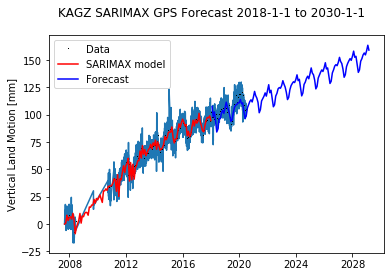

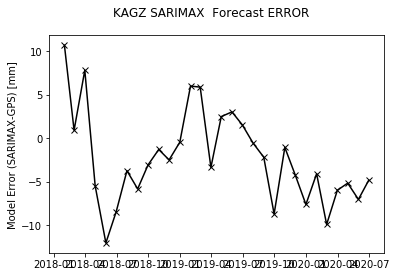

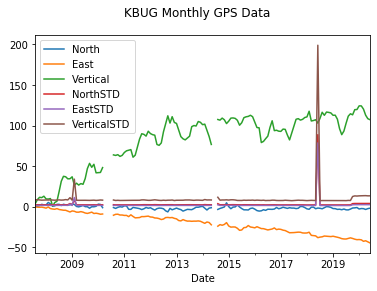

KBUG
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -175.601
Date:                            Wed, 29 Jul 2020   AIC                            373.202
Time:                                    17:05:31   BIC                            396.240
Sample:                                08-31-2007   HQIC                           382.214
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3723      0.564      0.660      0.509      -0.733       1.478
ar.L2         -0.0478      0.2

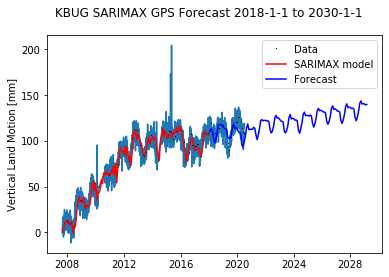

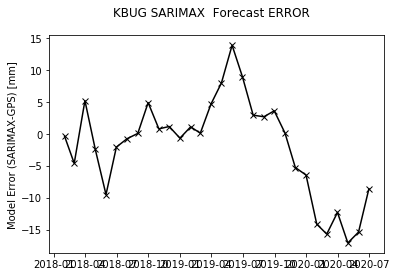

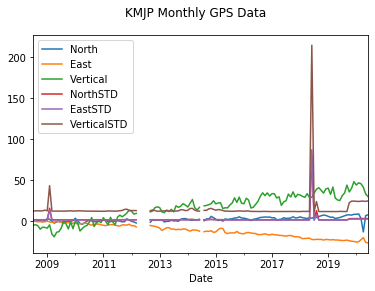

KMJP
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  114
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -131.615
Date:                            Wed, 29 Jul 2020   AIC                            285.229
Time:                                    17:05:46   BIC                            306.039
Sample:                                07-31-2008   HQIC                           293.124
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1465      0.189      0.776      0.438      -0.223       0.516
ar.L2          0.2250      0.1

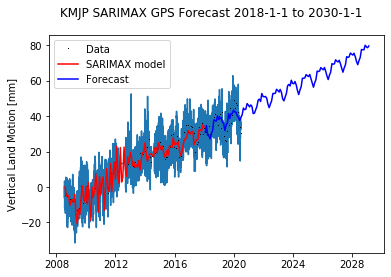

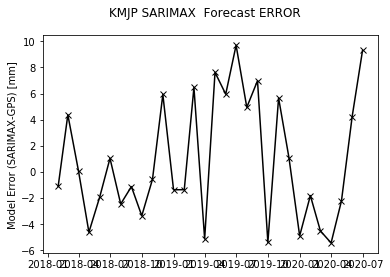

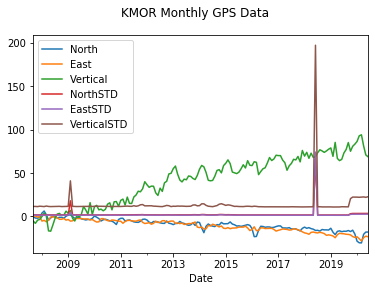

C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KMOR
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  124
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -166.245
Date:                            Wed, 29 Jul 2020   AIC                            354.489
Time:                                    17:06:10   BIC                            377.342
Sample:                                09-30-2007   HQIC                           363.410
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4993      0.260      1.924      0.054      -0.009       1.008
ar.L2         -0.0157      0.1

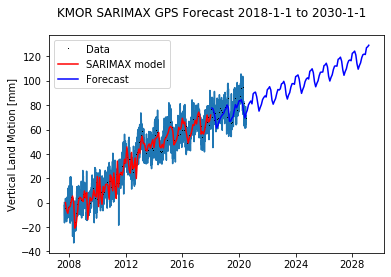

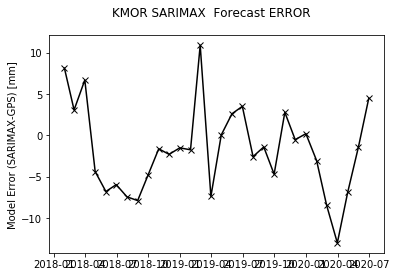

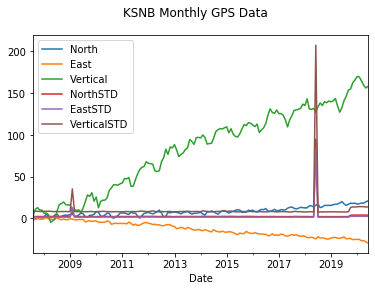

KSNB
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -161.091
Date:                            Wed, 29 Jul 2020   AIC                            344.182
Time:                                    17:06:27   BIC                            367.220
Sample:                                08-31-2007   HQIC                           353.194
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1997      0.844     -0.237      0.813      -1.854       1.454
ar.L2         -0.1925      0.4

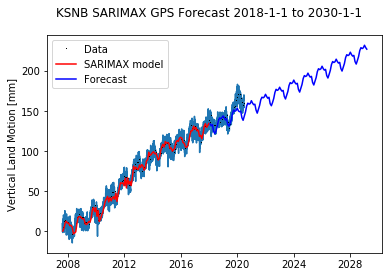

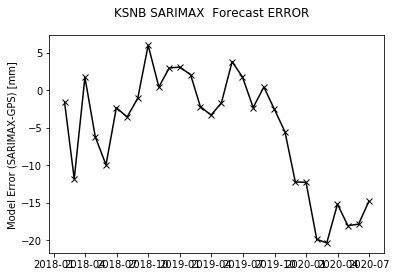

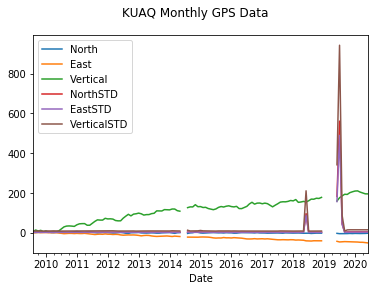

C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KUAQ
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  101
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 -94.948
Date:                            Wed, 29 Jul 2020   AIC                            211.896
Time:                                    17:06:52   BIC                            229.314
Sample:                                08-31-2009   HQIC                           217.975
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6841      0.269     -2.541      0.011      -1.212      -0.156
ar.L2         -0.0274      0.2

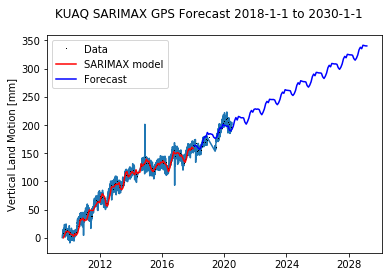

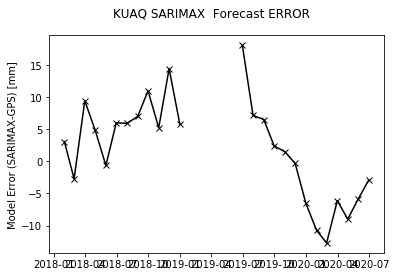

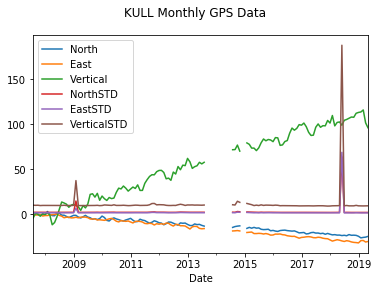

KULL
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -154.118
Date:                            Wed, 29 Jul 2020   AIC                            330.236
Time:                                    17:07:18   BIC                            353.274
Sample:                                08-31-2007   HQIC                           339.247
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7803      0.210      3.724      0.000       0.370       1.191
ar.L2         -0.2602      0.2

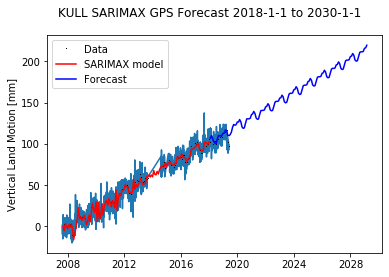

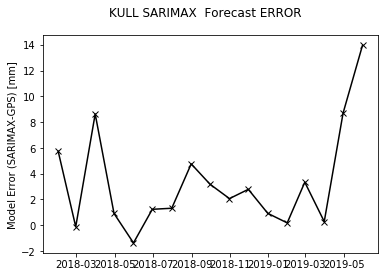

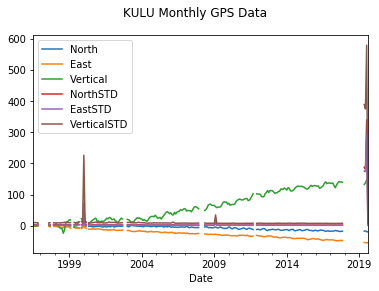

C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KULU
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  258
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -482.893
Date:                            Wed, 29 Jul 2020   AIC                            987.786
Time:                                    17:08:05   BIC                           1023.675
Sample:                                07-31-1996   HQIC                          1002.320
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0373      0.506      0.074      0.941      -0.954       1.029
ar.L2         -0.1236      0.2

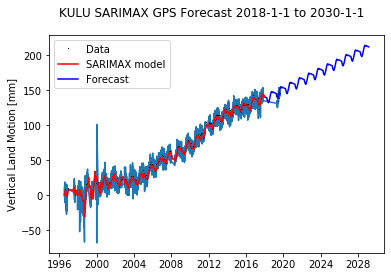

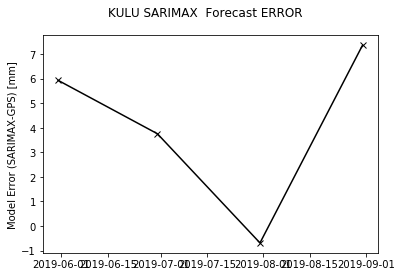

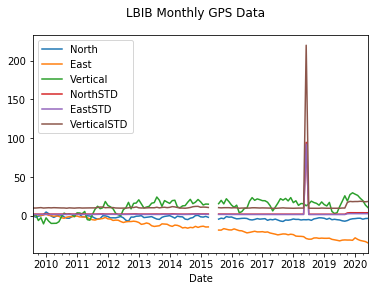

C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


LBIB
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  101
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 -93.299
Date:                            Wed, 29 Jul 2020   AIC                            208.597
Time:                                    17:08:32   BIC                            226.016
Sample:                                08-31-2009   HQIC                           214.677
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4654      0.315      1.478      0.139      -0.152       1.083
ar.L2          0.2088      0.2

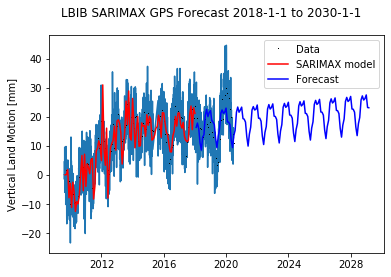

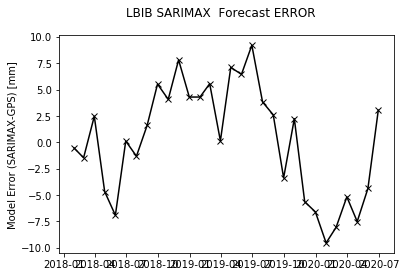

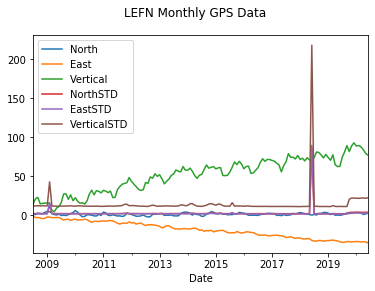

LEFN
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  114
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -120.822
Date:                            Wed, 29 Jul 2020   AIC                            263.643
Time:                                    17:08:51   BIC                            284.453
Sample:                                07-31-2008   HQIC                           271.539
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0923      1.338     -0.069      0.945      -2.714       2.530
ar.L2         -0.4176      1.0

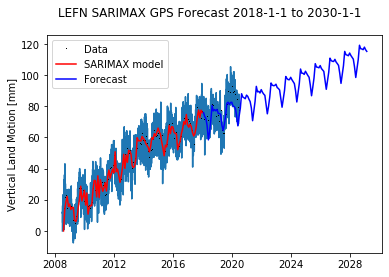

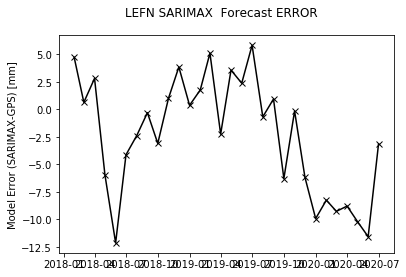

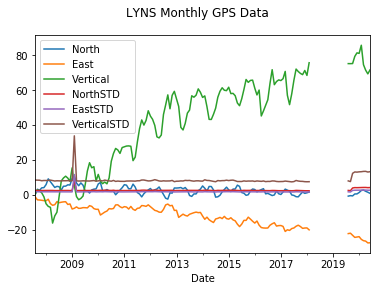

LYNS
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -162.877
Date:                            Wed, 29 Jul 2020   AIC                            347.755
Time:                                    17:09:04   BIC                            370.793
Sample:                                08-31-2007   HQIC                           356.766
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1277      1.089     -0.117      0.907      -2.262       2.007
ar.L2         -0.2749      0.4

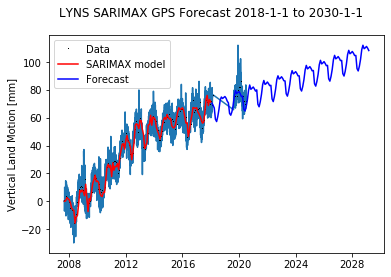

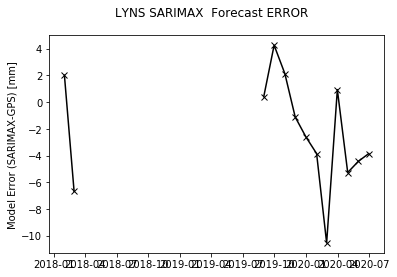

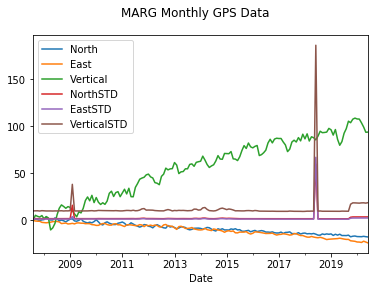

C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MARG
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -147.455
Date:                            Wed, 29 Jul 2020   AIC                            316.910
Time:                                    17:09:29   BIC                            339.948
Sample:                                08-31-2007   HQIC                           325.921
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3959      0.204      1.944      0.052      -0.003       0.795
ar.L2         -0.2999      0.1

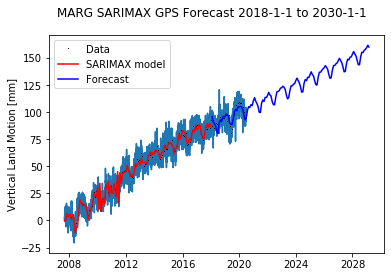

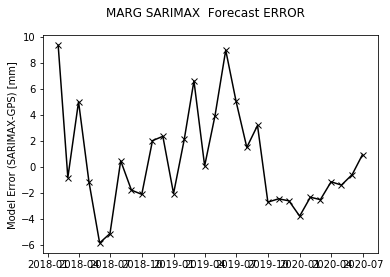

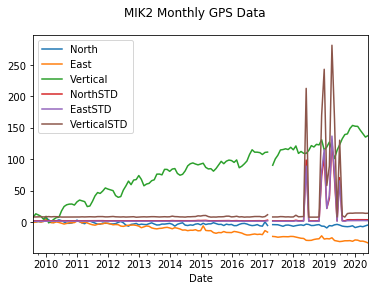

MIK2
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  101
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 -96.540
Date:                            Wed, 29 Jul 2020   AIC                            215.080
Time:                                    17:09:49   BIC                            232.499
Sample:                                08-31-2009   HQIC                           221.160
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0549      0.846     -1.247      0.212      -2.712       0.603
ar.L2         -0.5786      0.5

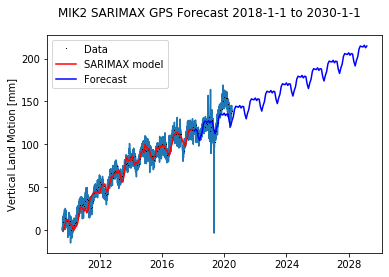

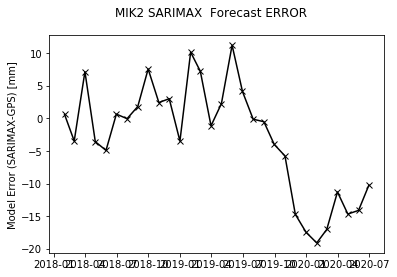

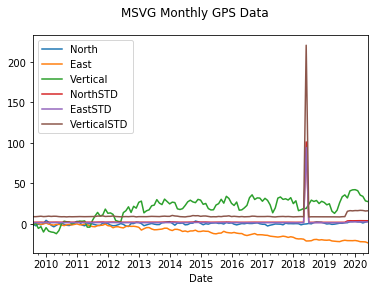

MSVG
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  101
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 -89.975
Date:                            Wed, 29 Jul 2020   AIC                            201.950
Time:                                    17:10:01   BIC                            219.369
Sample:                                08-31-2009   HQIC                           208.030
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0524      0.259      0.202      0.840      -0.456       0.560
ar.L2         -0.3237      0.2

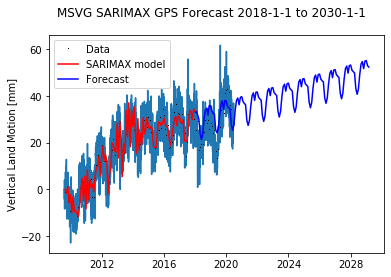

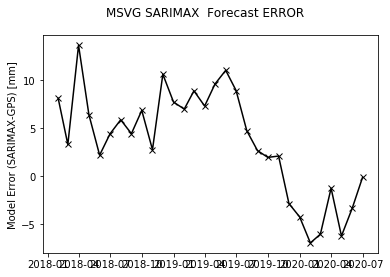

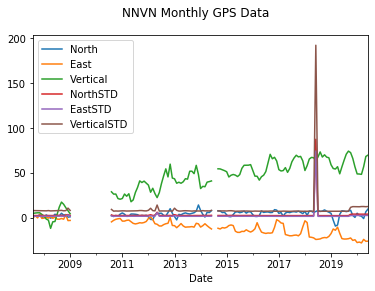

NNVN
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -160.414
Date:                            Wed, 29 Jul 2020   AIC                            342.827
Time:                                    17:10:17   BIC                            365.865
Sample:                                08-31-2007   HQIC                           351.838
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3574      0.358      0.999      0.318      -0.344       1.059
ar.L2         -0.0982      0.1

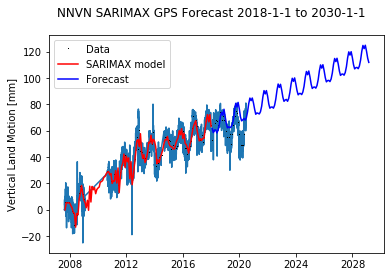

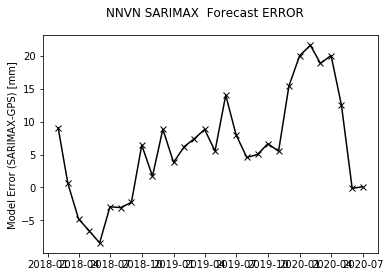

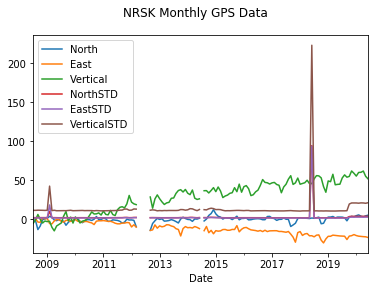

NRSK
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  114
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -130.904
Date:                            Wed, 29 Jul 2020   AIC                            283.808
Time:                                    17:10:35   BIC                            304.618
Sample:                                07-31-2008   HQIC                           291.703
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7417      0.467     -1.588      0.112      -1.657       0.174
ar.L2         -0.4387      0.3

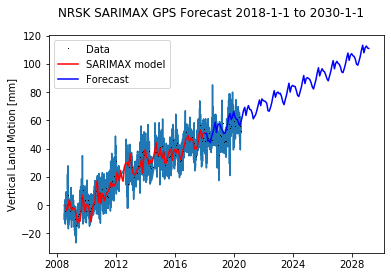

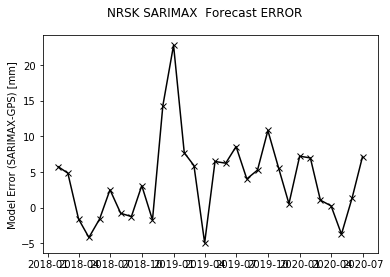

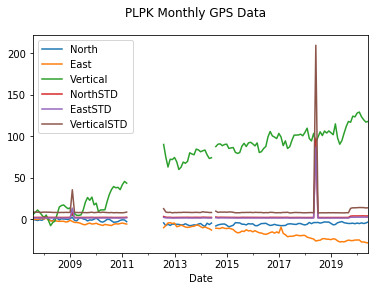

PLPK
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -170.584
Date:                            Wed, 29 Jul 2020   AIC                            363.168
Time:                                    17:10:48   BIC                            386.205
Sample:                                08-31-2007   HQIC                           372.179
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0811      0.735     -0.110      0.912      -1.522       1.360
ar.L2         -0.3305      0.2

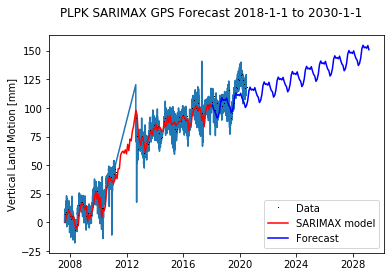

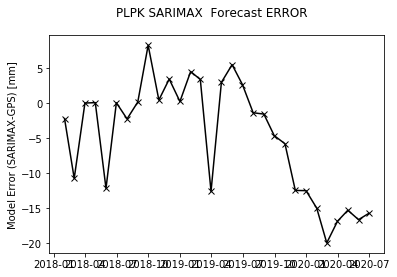

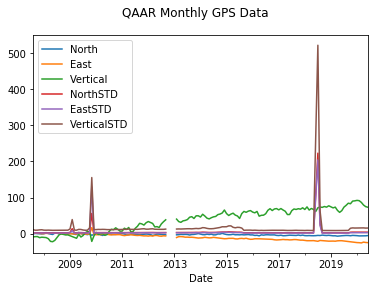

QAAR
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -167.818
Date:                            Wed, 29 Jul 2020   AIC                            357.635
Time:                                    17:11:01   BIC                            380.673
Sample:                                08-31-2007   HQIC                           366.647
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1999      0.344     -0.581      0.561      -0.874       0.474
ar.L2         -0.5470      0.1

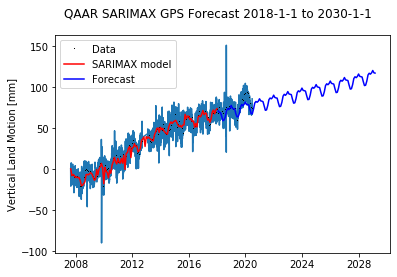

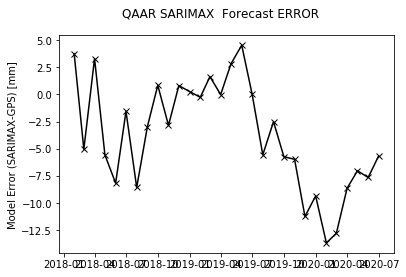

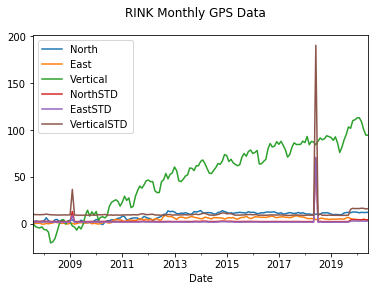

RINK
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -160.361
Date:                            Wed, 29 Jul 2020   AIC                            342.723
Time:                                    17:11:15   BIC                            365.761
Sample:                                08-31-2007   HQIC                           351.734
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0421      0.555      0.076      0.939      -1.045       1.129
ar.L2         -0.4240      0.2

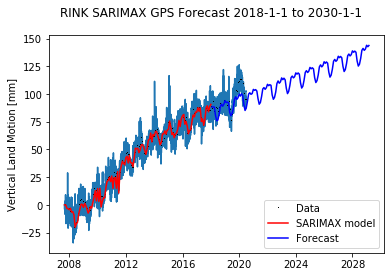

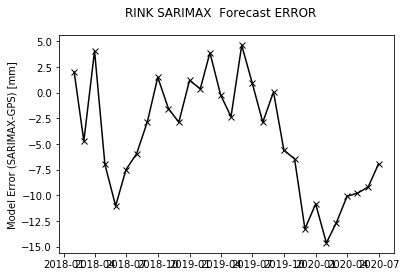

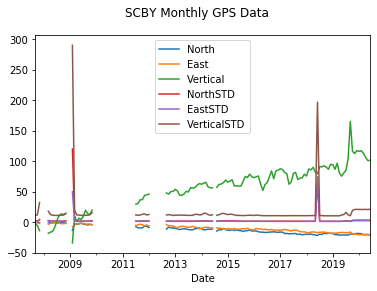

SCBY
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  124
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -180.898
Date:                            Wed, 29 Jul 2020   AIC                            383.796
Time:                                    17:11:33   BIC                            406.649
Sample:                                09-30-2007   HQIC                           392.717
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3048      0.774     -0.394      0.694      -1.821       1.212
ar.L2         -0.3466      0.4

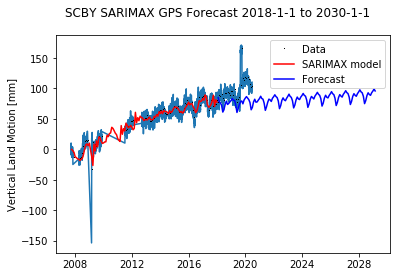

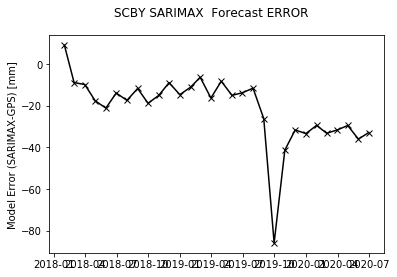

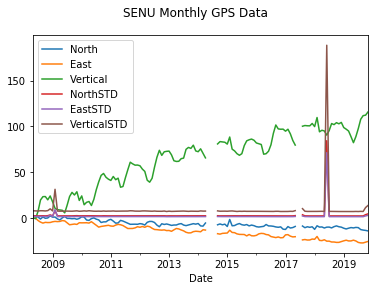

SENU
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  116
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -130.944
Date:                            Wed, 29 Jul 2020   AIC                            283.887
Time:                                    17:11:47   BIC                            305.138
Sample:                                05-31-2008   HQIC                           292.008
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0258      1.354     -0.019      0.985      -2.679       2.628
ar.L2         -0.3514      0.2

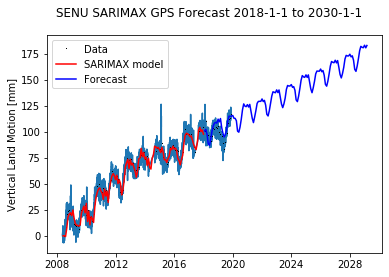

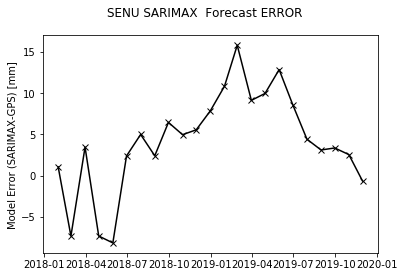

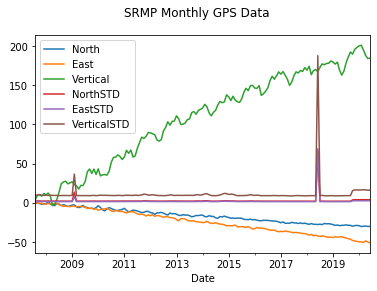

C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SRMP
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -158.173
Date:                            Wed, 29 Jul 2020   AIC                            338.346
Time:                                    17:12:12   BIC                            361.384
Sample:                                08-31-2007   HQIC                           347.358
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3743      0.816      0.459      0.646      -1.225       1.973
ar.L2         -0.1632      0.3

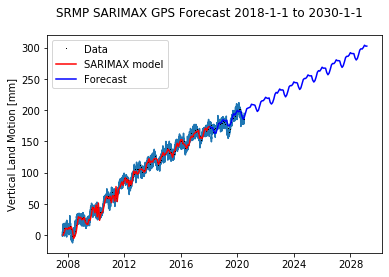

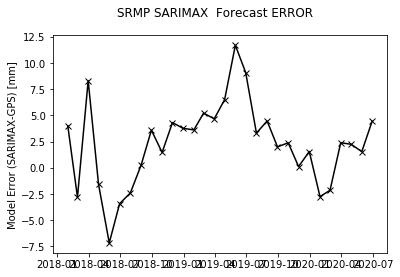

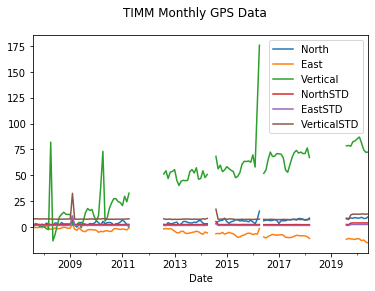

TIMM
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -237.732
Date:                            Wed, 29 Jul 2020   AIC                            497.465
Time:                                    17:12:32   BIC                            520.503
Sample:                                08-31-2007   HQIC                           506.476
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2174      0.330     -0.659      0.510      -0.864       0.430
ar.L2         -0.5735      0.1

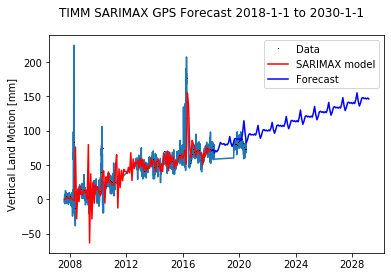

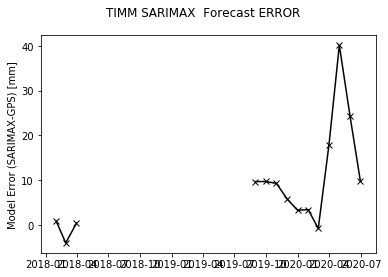

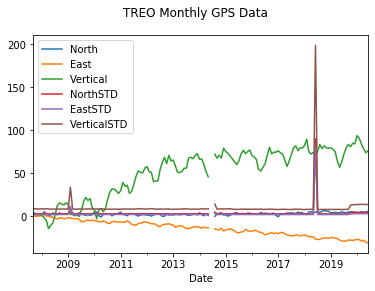

TREO
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  124
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -165.733
Date:                            Wed, 29 Jul 2020   AIC                            353.467
Time:                                    17:12:48   BIC                            376.320
Sample:                                09-30-2007   HQIC                           362.388
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1695      3.314     -0.051      0.959      -6.666       6.327
ar.L2         -0.1337      1.1

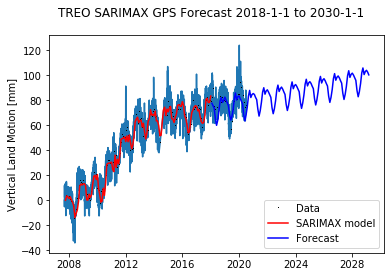

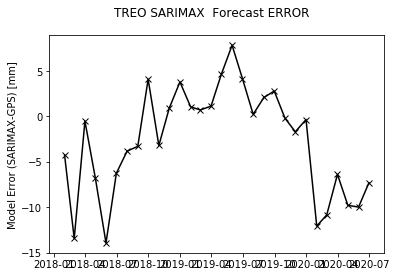

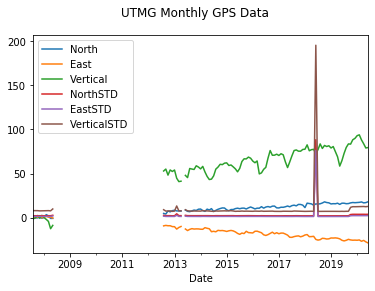

UTMG
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  125
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                -160.271
Date:                            Wed, 29 Jul 2020   AIC                            342.542
Time:                                    17:13:14   BIC                            365.579
Sample:                                08-31-2007   HQIC                           351.553
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6073      0.197      3.088      0.002       0.222       0.993
ar.L2         -0.0123      0.2

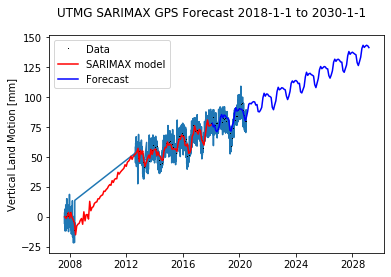

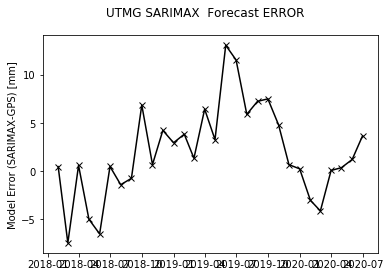

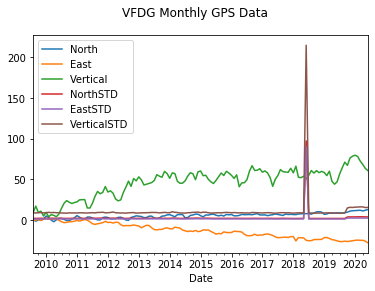

C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


VFDG
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  101
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 -94.799
Date:                            Wed, 29 Jul 2020   AIC                            211.598
Time:                                    17:13:34   BIC                            229.017
Sample:                                08-31-2009   HQIC                           217.677
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2469      6.142     -0.040      0.968     -12.285      11.791
ar.L2         -0.1085      4.0

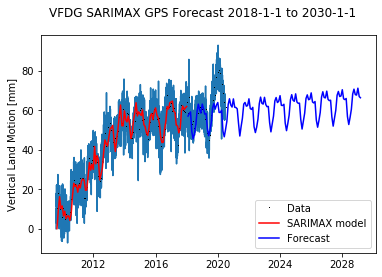

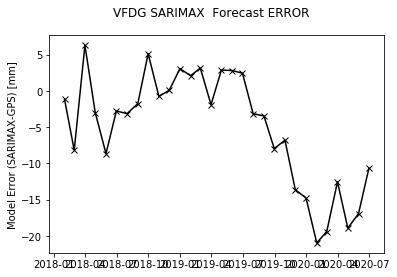

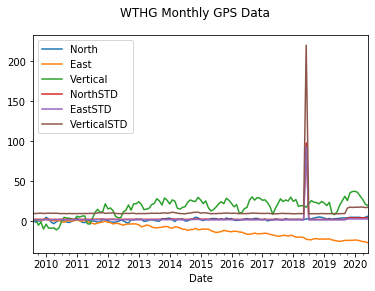

WTHG
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  101
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 -89.105
Date:                            Wed, 29 Jul 2020   AIC                            200.210
Time:                                    17:13:54   BIC                            217.629
Sample:                                08-31-2009   HQIC                           206.290
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3132      0.234      1.341      0.180      -0.145       0.771
ar.L2          0.3432      0.1

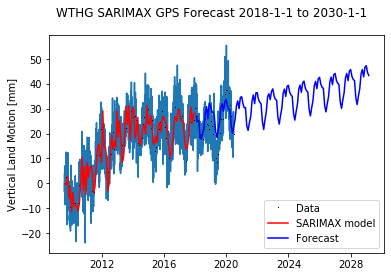

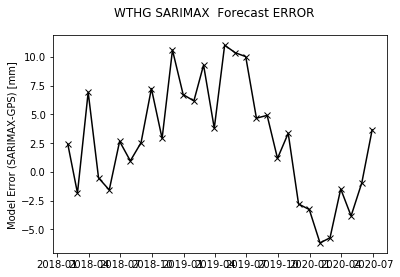

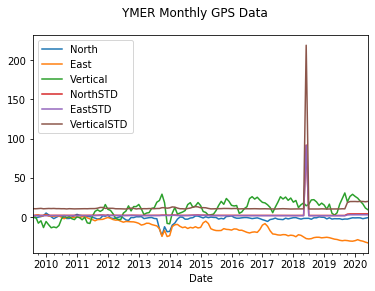

C:\Users\jhsan\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YMER
                                     SARIMAX Results                                      
Dep. Variable:                           Vertical   No. Observations:                  101
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 -88.627
Date:                            Wed, 29 Jul 2020   AIC                            199.255
Time:                                    17:14:14   BIC                            216.674
Sample:                                08-31-2009   HQIC                           205.334
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0152      0.261      0.058      0.953      -0.496       0.527
ar.L2          0.0850      0.2

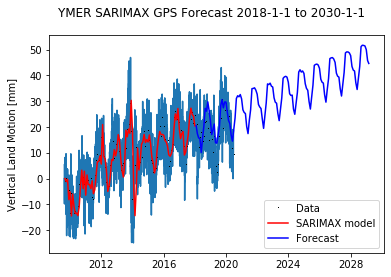

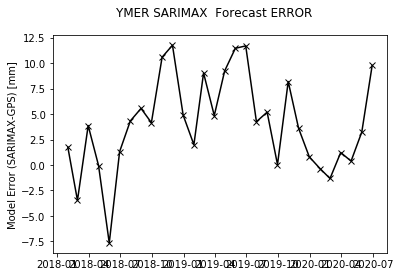

In [21]:
for f, filepath in enumerate(filenames):
    df = read_GPS_nam14_UNAVCO(filepath)
    df_monthly = monthly_averaging(df, filepath[-18:-14])
    plt.plot(df['Vertical'])
    test_SARIMAX_GPS_Monthly(df_monthly, 'Vertical', filepath[-18:-14], 134, '2018-1-1', '2030-1-1', 'M')

In [ ]:
for f, filepath in enumerate(filenames):
    df = read_GPS_nam14_UNAVCO(filepath)
    test_SARIMAX_GPS_Monthly(df, 'Vertical', filepath[-18:-14], 134, '2018-1-1', '2030-1-1', 'M')